In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

pd.set_option('max_columns', 200)
pd.set_option('max_rows', 80)

In [12]:
def cv_score(df_train, y_train, kfolds, pipeline, imp_coef=False):
    oof = np.zeros(len(df_train))
    train = df_train.copy()
    
    feat_df = pd.DataFrame()
    
    for n_fold, (train_index, test_index) in enumerate(kfolds.split(train.values)):
            
        trn_data = train.iloc[train_index][:]
        val_data = train.iloc[test_index][:]
        
        trn_target = y_train.iloc[train_index].values.ravel()
        val_target = y_train.iloc[test_index].values.ravel()
        
        pipeline.fit(trn_data, trn_target)

        oof[test_index] = pipeline.predict(val_data).ravel()

        if imp_coef:
            try:
                fold_df = get_coef(pipeline)
            except AttributeError:
                fold_df = get_feature_importance(pipeline)
                
            fold_df['fold'] = n_fold + 1
            feat_df = pd.concat([feat_df, fold_df], axis=0)
       
    if imp_coef:
        feat_df = feat_df.groupby('feat')['score'].agg(['mean', 'std'])
        feat_df['abs_sco'] = (abs(feat_df['mean']))
        feat_df = feat_df.sort_values(by=['abs_sco'],ascending=False)
        del feat_df['abs_sco']
        return oof, feat_df
    else:    
        return oof
    

def get_coef(pipe):
    imp = pipe.steps[-1][1].coef_.tolist()
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result['abs_res'] = abs(result['score'])
    result = result.sort_values(by=['abs_res'],ascending=False)
    del result['abs_res']
    return result


def get_feature_importance(pipe):
    imp = pipe.steps[-1][1].feature_importances_.tolist() #it's a pipeline
    feats = pipe.steps[-2][1].get_feature_names()
    result = pd.DataFrame({'feat':feats,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


def create_targets(data):
    unique_plays = data[['PlayId', 'Yards']].drop_duplicates()
    simple = unique_plays['Yards'].reset_index(drop=True)
    # As total distance of the rusher
    rushers = data[data.has_ball].copy().reset_index(drop=True)
    tot_dist = rushers['Yards'] + rushers['from_yardline']
    # As percentage of Yards remaining to be gained
    unique_plays = data[['PlayId', 'YardLine', 'Yards']].drop_duplicates().reset_index(drop=True)
    perc_gained = unique_plays['Yards'] / (110 - unique_plays['YardLine'])
    # As both
    perc_dist = tot_dist / (110 - rushers['X'])
    
    return simple, tot_dist, perc_gained, perc_dist


def get_crps(train, inf_pred, y):
    y_pred = np.zeros((len(train),199))
    y_true = np.zeros((len(train),199))

    for i,p in enumerate(inf_preds):
        p += 99
        for j in range(199):
            if j >= p + 10:
                y_pred[i][j] = 1.0
            elif j >= p - 10:
                y_pred[i][j] = (j + 10 - p) * 0.05

    for i,p in enumerate(y):
        p += 99
        for j in range(199):
            if j >= p:
                y_true[i][j]=1.0
                
    return np.sum(np.power(y_pred - y_true, 2)) / (199 * (len(train)))

In [29]:
def _plot_diagonal(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    low = min(xmin, xmax)
    high = max(xmin, xmax)
    scl = (high - low) / 100
    
    line = pd.DataFrame({'x': np.arange(low, high ,scl), # small hack for a diagonal line
                         'y': np.arange(low, high ,scl)})
    ax.plot(line.x, line.y, color='black', linestyle='--')
    
    return ax


def plot_predictions(data, true_label, pred_label, feature=None, hue=None, legend=False, savename='test.png'):
    '''
    Plot prediction vs true label or a specific feature. It also plots the residuals plot
    '''
    
    tmp = data.copy()
    tmp['Prediction'] = pred_label
    tmp['True Label'] = true_label
    tmp['Residual'] = tmp['True Label'] - tmp['Prediction']
    
    diag = False
    alpha = 0.7
    label = ''
    
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    if feature is None:
        feature = 'True Label'
        diag = True
    else:
        legend = 'full'
        sns.scatterplot(x=feature, y='True Label', data=tmp, ax=ax[0], label='True',
                         hue=hue, legend=legend, alpha=alpha)
        label = 'Predicted'
        alpha = 0.4

    sns.scatterplot(x=feature, y='Prediction', data=tmp, ax=ax[0], label=label,
                         hue=hue, legend=legend, alpha=alpha)
    if diag:
        ax[0] = _plot_diagonal(ax[0])
    
    sns.scatterplot(x=feature, y='Residual', data=tmp, ax=ax[1], 
                    hue=hue, legend=legend, alpha=0.7)
    ax[1].axhline(y=0, color='r', linestyle='--')
    
    ax[0].set_title(f'{feature} vs Predictions')
    ax[1].set_title(f'{feature} vs Residuals')
    
    if not savename.endswith('.png'):
        savename += '.png'
    plt.savefig('../plots/' + savename)
    plt.close()

In [30]:
class transformation(TransformerMixin, BaseEstimator):
    def __init__(self, mean_weight=10):
        self.columns = None

        
    def fit(self, X, y=None):
        return self
    
    
    def stats_by_play(self, data):
        avg_by_play = data.groupby(['PlayId', 
                                    'Team', 
                                    'offense_team'], as_index=False)[['PlayerHeight', 
                                                                      'PlayerWeight',
                                                                      'age',
                                                                      'S', 'A']].mean()
        spread = data.groupby(['PlayId', 
                               'Team', 
                               'offense_team'])[['X', 'Y']].std().reset_index()
        tot_momentum = data.groupby(['PlayId', 
                                     'Team', 
                                     'offense_team'], as_index=False)[['X_speed', 'Y_speed',
                                                                       'PlayerWeight',
                                                                       'X_acceleration','Y_acceleration']].sum()
        
        tot_momentum['x_momentum'] = tot_momentum['X_speed'] * tot_momentum['PlayerWeight']
        tot_momentum['y_momentum'] = tot_momentum['Y_speed'] * tot_momentum['PlayerWeight']
        tot_momentum['x_force'] = tot_momentum['X_acceleration'] * tot_momentum['PlayerWeight']
        tot_momentum['y_force'] = tot_momentum['Y_acceleration'] * tot_momentum['PlayerWeight']
        tot_momentum.drop(['X_speed', 'Y_speed',
                           'PlayerWeight',  
                           'X_acceleration','Y_acceleration'], axis=1, inplace=True)

        avg_by_play = pd.merge(avg_by_play, tot_momentum, on=['PlayId', 'Team', 'offense_team'])
        avg_by_play = pd.merge(avg_by_play, spread, on=['PlayId', 'Team', 'offense_team'])

        poss_team = avg_by_play[avg_by_play.Team == avg_by_play.offense_team].copy()
        def_team = avg_by_play[avg_by_play.Team != avg_by_play.offense_team].copy()

        poss_team.rename(columns={'PlayerHeight': 'poss_avg_height', 
                                  'PlayerWeight': 'poss_avg_weight',
                                  'age': 'poss_avg_age',
                                  'X': 'poss_std_X',
                                  'Y': 'poss_std_Y',
                                  'S': 'poss_avg_S', 
                                  'A': 'poss_avg_A', 
                                  'x_momentum': 'poss_x_momentum', 
                                  'y_momentum': 'poss_y_momentum', 
                                  'x_force': 'poss_x_force', 
                                  'y_force': 'poss_y_force'}, inplace=True)
        def_team.rename(columns={'PlayerHeight': 'def_avg_height', 
                                  'PlayerWeight': 'def_avg_weight', 
                                  'age': 'def_avg_age',
                                  'X': 'def_std_X',
                                  'Y': 'def_std_Y',
                                  'S': 'def_avg_S', 
                                  'A': 'def_avg_A',
                                  'x_momentum': 'def_x_momentum', 
                                  'y_momentum': 'def_y_momentum', 
                                  'x_force': 'def_x_force', 
                                  'y_force': 'def_y_force'}, inplace=True)

        avg_by_play = pd.merge(poss_team.drop('Team', axis=1), 
                               def_team.drop('Team', axis=1), on=['PlayId', 'offense_team'])
        
        avg_by_play['tot_x_momenumt'] = avg_by_play['poss_x_momentum'] - avg_by_play['def_x_momentum']
        avg_by_play['tot_x_force'] = avg_by_play['poss_x_force'] - avg_by_play['def_x_force']
        avg_by_play['height_diff'] = avg_by_play['poss_avg_height'] - avg_by_play['def_avg_height']
        avg_by_play['weight_diff'] = avg_by_play['poss_avg_weight'] - avg_by_play['def_avg_weight']
        avg_by_play['age_diff'] = avg_by_play['poss_avg_age'] - avg_by_play['def_avg_age']
        avg_by_play['X_diff'] = avg_by_play['poss_std_X'] - avg_by_play['def_std_X']
        avg_by_play['Y_diff'] = avg_by_play['poss_std_Y'] - avg_by_play['def_std_Y']

        return avg_by_play
    
    
    def process_play(self, X):
        cols_by_play = ['GameId', 'PlayId', 'YardLine', 
                'Quarter', 'GameClock', 'Down', 'Distance',
                'OffenseFormation', 'DefendersInTheBox',  
                'Location', 'StadiumType', 'Turf', 
                'GameWeather','Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 
                'PlayDirection', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay']
        train_play = X[cols_by_play].drop_duplicates()
        avg_by_play = self.stats_by_play(X)
        train_play = pd.merge(train_play, avg_by_play.drop('offense_team', axis=1), on=['PlayId'])

        return train_play
    
    
    def dropper(self, X):
        cleaned = X.copy()
        to_drop = ['GameId', 'WindDirection', 'WindSpeed', 'GameWeather', 
                    'PlayDirection', 'StadiumType', 'Turf', 'Location', 
                   'GameClock', 'distance_from_ball', 'Quarter', 'Down', 
                   'OffenseFormation', 'Temperature', 'Humidity', 
                   'HomeScoreBeforePlay','VisitorScoreBeforePlay']
        for col in to_drop:
            try:
                del cleaned[col]
            except KeyError:
                pass
        
        return cleaned
    
    
    def transform(self, X, y=None):
        train_play = self.process_play(X)
        carriers = X[X.has_ball].copy()

        to_drop = ['GameId', 'NflId', 'Team', 'Orientation','YardLine', 'Quarter', 'GameClock', 'PossessionTeam',
           'Down', 'FieldPosition', 'HomeScoreBeforePlay',
           'VisitorScoreBeforePlay', 'NflIdRusher', 'OffensePersonnel','DefensePersonnel',
               'PlayDirection', 'Position', 'HomeTeamAbbr',
           'VisitorTeamAbbr', 'Location', 'StadiumType', 'GameWeather',
           'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'to_left',
           'has_ball', 'offense_team', 'Distance',
           'OffenseFormation', 'DefendersInTheBox', 'Turf']

        carriers.drop(to_drop, axis=1, inplace=True)

        full_train = pd.merge(carriers, train_play, on='PlayId')
        
        full_train = self.dropper(full_train)
        
        self.columns = full_train.columns

        return full_train
    
    
    def get_features_name(self):
        return self.columns

In [31]:
class df_imputer(TransformerMixin, BaseEstimator):
    '''
    Just a wrapper for the SimpleImputer that keeps the dataframe structure
    '''
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imp = None
        self.statistics_ = None

    def fit(self, X, y=None):
        self.imp = SimpleImputer(strategy=self.strategy)
        self.imp.fit(X)
        self.statistics_ = pd.Series(self.imp.statistics_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled

    
class df_scaler(TransformerMixin, BaseEstimator):
    '''
    Wrapper of StandardScaler or RobustScaler
    '''
    def __init__(self, method='standard'):
        self.scl = None
        self.scale_ = None
        self.method = method
        if self.method == 'sdandard':
            self.mean_ = None
        elif method == 'robust':
            self.center_ = None
        self.columns = None  # this is useful when it is the last step of a pipeline before the model

    def fit(self, X, y=None):
        if self.method == 'standard':
            self.scl = StandardScaler()
            self.scl.fit(X)
            self.mean_ = pd.Series(self.scl.mean_, index=X.columns)
        elif self.method == 'robust':
            self.scl = RobustScaler()
            self.scl.fit(X)
            self.center_ = pd.Series(self.scl.center_, index=X.columns)
        self.scale_ = pd.Series(self.scl.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xscl = self.scl.transform(X)
        Xscaled = pd.DataFrame(Xscl, index=X.index, columns=X.columns)
        self.columns = X.columns
        return Xscaled

    def get_feature_names(self):
        return list(self.columns)


class dummify(TransformerMixin, BaseEstimator):
    '''
    Wrapper for get dummies
    Via match_cols, it is possible to ask the transformer to make sure that all the dummies are there
    Missing dummies are introduced with a column of 0's
    Extra dummies are dropped
    '''
    def __init__(self, drop_first=False, match_cols=True):
        self.drop_first = drop_first
        self.columns = []  # useful to well behave with FeatureUnion
        self.match_cols = match_cols

    def fit(self, X, y=None):
        return self
    
    def match_columns(self, X):
        miss_train = list(set(X.columns) - set(self.columns))
        miss_test = list(set(self.columns) - set(X.columns))
        
        err = 0
        
        if len(miss_test) > 0:
            for col in miss_test:
                X[col] = 0  # insert a column for the missing dummy
                err += 1
        if len(miss_train) > 0:
            for col in miss_train:
                del X[col]  # delete the column of the extra dummy
                err += 1
                
        if err > 0:
            warnings.warn('The dummies in this set do not match the ones in the train set, we corrected the issue.',
                         UserWarning)
            
        return X[self.columns]
        
        
    def transform(self, X):
        X = pd.get_dummies(X, drop_first=self.drop_first)
        if (len(self.columns) > 0):
            if self.match_cols:
                X = self.match_columns(X)
        else:
            self.columns = X.columns
        return X
    
    def get_features_name(self):
        return list(self.columns)

In [32]:
df_train = pd.read_csv('../data_processed/train_processed.csv', dtype={'WindSpeed': 'object'})

df_train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,Yards,PlayerHeight,PlayerWeight,Position,HomeTeamAbbr,VisitorTeamAbbr,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection,to_left,has_ball,offense_team,from_yardline,X_speed,Y_speed,X_acceleration,Y_acceleration,age,distance_from_ball,closest_opponent,opponents_in_6,teammates_in_6
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,81.99,1.620015,496723,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,72,212,SS,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,1.09,1.687953,-0.083145,1.128632,-0.055594,10480,6.480872,4.59331,3.0,7.0
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,27.61,1.244420,2495116,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,75,288,DE,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,0.33,0.397828,0.134657,1.278734,0.432828,10394,4.593310,4.59331,3.0,7.0
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.01,1.174083,2495493,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,75,270,DE,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,1.00,1.125250,0.471395,0.544178,0.227970,10457,5.448982,4.59331,3.0,7.0
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,359.77,2.868623,2506353,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,75,245,ILB,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,3.54,0.113229,-0.404449,0.145580,-0.520006,12709,7.820038,4.59331,3.0,7.0
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,12.63,1.844638,2530794,45,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,8,72,206,FS,NE,KC,"Foxborough, MA",Outdoor,0,Clear and warm,63.0,77.0,8,SW,True,False,home,5.68,1.752185,-0.492187,2.339456,-0.657151,10980,10.622476,4.59331,3.0,7.0


In [33]:
folds = KFold(5, shuffle=True, random_state=541)

plays = df_train[df_train.has_ball][['PlayId', 
                                     'YardLine', 
                                     'from_yardline', 
                                     'X']].drop_duplicates().reset_index(drop=True)


y1, y2, y3, y4 = create_targets(df_train)

del df_train['Yards']

In [34]:
transf_pipe = Pipeline([('trsf', transformation())])

full_train = transf_pipe.fit_transform(df_train)

full_train.head()

,PlayId,X,Y,S,A,Dis,Dir,PlayerHeight,PlayerWeight,from_yardline,X_speed,Y_speed,X_acceleration,Y_acceleration,age,closest_opponent,opponents_in_6,teammates_in_6,YardLine,Distance,DefendersInTheBox,poss_avg_height,poss_avg_weight,poss_avg_age,poss_avg_S,poss_avg_A,poss_x_momentum,poss_y_momentum,poss_x_force,poss_y_force,poss_std_X,poss_std_Y,def_avg_height,def_avg_weight,def_avg_age,def_avg_S,def_avg_A,def_x_momentum,def_y_momentum,def_x_force,def_y_force,def_std_X,def_std_Y,tot_x_momenumt,tot_x_force,height_diff,weight_diff,age_diff,X_diff,Y_diff
0,20170907000118,41.25,22.803333,3.63,3.35,0.38,0.423417,70,205,3.75,1.491487,3.309436,1.376441,3.054163,9349,4.593310,3.0,7.0,45,2,6.0,74.727273,259.181818,10374.454545,2.106364,1.358182,30394.065885,42824.323203,14808.310917,29092.727988,1.772665,5.855606,73.636364,233.545455,10101.272727,1.314545,1.025455,21967.405111,4867.003640,11406.041625,-783.137540,5.294079,7.014714,8426.660774,3402.269293,1.090909,25.636364,273.181818,-3.521414,-1.159107
1,20170907000139,48.93,26.173333,3.06,2.41,0.34,5.546656,70,205,4.07,-2.055465,2.266862,-1.618847,1.785339,9349,4.287773,3.0,7.0,53,10,6.0,74.727273,259.181818,10374.454545,2.094545,1.541818,5361.669172,36553.979512,1503.788380,27039.089576,2.001380,6.932502,73.636364,233.545455,10101.272727,1.639091,1.592727,-3627.891830,6256.141431,-2706.292685,4533.856018,5.406292,7.190716,8989.561002,4210.081065,1.090909,25.636364,273.181818,-3.404912,-0.258215
2,20170907000189,71.34,34.223333,5.77,2.42,0.60,0.838456,70,205,3.66,4.290640,3.857889,1.799541,1.618040,9349,4.221670,2.0,6.0,75,10,7.0,74.727273,259.181818,10374.454545,3.682727,1.419091,86277.195695,48107.583525,33664.932926,23232.912519,2.115286,6.044208,73.636364,233.545455,10101.272727,3.244545,2.092727,82977.152392,12860.033647,52837.531067,8496.045083,4.720893,6.577620,3300.043303,-19172.598141,1.090909,25.636364,273.181818,-2.605606,-0.533412
3,20170907000345,104.47,27.973333,4.45,3.20,0.46,6.188239,71,210,3.53,-0.421875,4.429957,-0.303371,3.185587,9808,4.528002,7.0,9.0,108,2,9.0,76.181818,282.545455,10320.636364,2.141818,0.880909,-39812.029305,39225.794933,-11636.814745,16186.365888,1.898686,3.154869,73.727273,257.454545,10390.181818,1.555455,1.293636,-37637.593645,-4639.830146,-26960.759277,-9328.539063,0.962418,4.505029,-2174.435660,15323.944532,2.454545,25.090909,-69.545455,0.936268,-1.350160
4,20170907000395,29.99,27.120000,3.90,2.53,0.44,5.097758,71,216,5.01,-3.613974,1.466013,-2.344450,0.951029,8069,4.288088,3.0,6.0,35,10,7.0,76.909091,268.454545,9732.818182,2.644545,1.620000,-31427.161922,20004.068984,-13921.201825,13577.076191,2.056883,7.423977,73.181818,242.454545,9967.181818,2.322727,2.121818,-54049.085285,-11151.985380,-50459.233839,-5737.783040,5.391251,7.864325,22621.923362,36538.032014,3.727273,26.000000,-234.363636,-3.334368,-0.440348


In [36]:
models = [('forest', RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=10, 
                                           criterion='mae', max_features='sqrt')), 
          ('svr', SVR(gamma='auto')),
          ('xgb', xgb.XGBRegressor(n_estimators=500, objective='reg:squarederror', n_jobs=-1))]

mod_name = []
rmse_train_simple = []
mae_train_simple = []
crps_train_simple = []
importances = {}
oof = {}
avg_preds = np.zeros(len(full_train))


for model in models:
    
    train = full_train.copy()
    mod_play = plays.copy()
    del train['PlayId']
    print(model[0])
    mod_name.append(model[0])
    
    model_pipe = Pipeline([('dummifier', dummify(drop_first=True)),
                           ('Imputer', df_imputer()),
                           ('scl', df_scaler(method='standard'))] + [model])
    if model[0] == 'svr':        
        %time inf_preds = cv_score(train, y1, folds, model_pipe)
    else:
        %time inf_preds, imps = cv_score(train, y1, folds, model_pipe, imp_coef=True)
        importances[model[0]] = imps
    
    mod_play['simple'] = inf_preds
    mod_play.loc[mod_play.simple > (110 - mod_play.YardLine), 'simple'] = (110 - mod_play.YardLine)
    inf_preds = mod_play['simple']
    
    oof[model[0]] = inf_preds
    
    plot_predictions(train, y1, inf_preds, savename='../plots/' + model[0] + '.png')
    
    avg_preds += inf_preds / 3
    
    crps = get_crps(train, inf_preds, y1)

    rmse_train_simple.append(np.sqrt(mean_squared_error(y1, inf_preds)))
    mae_train_simple.append(mean_absolute_error(y1, inf_preds))
    crps_train_simple.append(crps)
    
    print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y1, inf_preds)), 4)}')
    print(f'\tTrain set MAE: {round(mean_absolute_error(y1, inf_preds), 4)}')
    print(f'\tTrain set CRPS: {round(crps, 4)}')
    
    print('- -'*20)
    
crps = get_crps(train, avg_preds, y1)   
    
print(f'\tTrain set RMSE average: {round(np.sqrt(mean_squared_error(y1, avg_preds)), 4)}')
print(f'\tTrain set MAE average: {round(mean_absolute_error(y1, avg_preds), 4)}')
print(f'\tTrain set CRPS average: {round(crps, 4)}')

print('_'*60)
print('\n')
    
    
results = pd.DataFrame({'model_name': mod_name, 
                        'rmse_train': rmse_train_simple, 
                        'mae_train': mae_train_simple, 
                        'crps_train': crps_train_simple})

results

forest
CPU times: user 1h 31min 38s, sys: 8.41 s, total: 1h 31min 46s
Wall time: 16min 52s
	Train set RMSE: 6.31
	Train set MAE: 3.4209
	Train set CRPS: 0.0149
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
svr
CPU times: user 2min 51s, sys: 145 ms, total: 2min 51s
Wall time: 2min 51s
	Train set RMSE: 6.2991
	Train set MAE: 3.3619
	Train set CRPS: 0.0148
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
xgb
CPU times: user 1min 29s, sys: 123 ms, total: 1min 29s
Wall time: 16.5 s
	Train set RMSE: 6.2305
	Train set MAE: 3.6253
	Train set CRPS: 0.0152
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
	Train set RMSE average: 6.204
	Train set MAE average: 3.3921
	Train set CRPS average: 0.0152
____________________________________________________________




,model_name,rmse_train,mae_train,crps_train
0,forest,6.310036,3.420852,0.014874
1,svr,6.299120,3.361885,0.014760
2,xgb,6.230538,3.625267,0.015182


In [38]:
#oof = pd.DataFrame(oof)

oof['true'] = y1

oof.head()

,forest,svr,xgb,true
0,5.060,6.095010,8.334285,8
1,3.405,3.950375,5.076822,3
2,3.715,4.868108,5.344259,5
3,1.680,1.804165,2.000000,2
4,3.575,0.727547,4.509535,7


In [39]:
oof.corr()

,forest,svr,xgb,true
forest,1.000000,0.824309,0.787996,0.271646
svr,0.824309,1.000000,0.724640,0.284728
xgb,0.787996,0.724640,1.000000,0.266571
true,0.271646,0.284728,0.266571,1.000000


In [40]:
importances['forest']

,mean,std
feat,,
A,0.104516,0.003580
Y_acceleration,0.075632,0.006393
def_y_momentum,0.052389,0.002570
def_std_X,0.037647,0.001720
X_diff,0.035493,0.003537
Y_speed,0.032626,0.001951
S,0.029756,0.001905
poss_y_momentum,0.026189,0.003049
def_y_force,0.025748,0.002045


In [41]:
importances['xgb']

,mean,std
feat,,
A,0.061975,0.004055
YardLine,0.036866,0.008859
DefendersInTheBox,0.036319,0.005910
def_std_X,0.034710,0.010540
def_y_momentum,0.032440,0.002871
Y_acceleration,0.031294,0.002133
S,0.031180,0.003467
X_diff,0.026744,0.003477
X,0.024790,0.002266


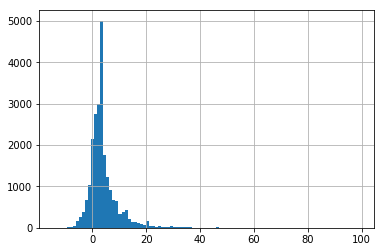

In [42]:
oof['true'].hist(bins=100)

In [71]:
tmp = y1.copy()

scal = StandardScaler()

tmp = scal.fit_transform(pd.DataFrame(tmp))

pd.Series(tmp.T[0])

0        0.588498
1       -0.188363
2        0.122381
3       -0.343735
4        0.433126
           ...   
23166   -0.499107
23167   -0.032991
23168   -0.032991
23169   -0.343735
23170    1.054614
Length: 23171, dtype: float64

In [72]:
tmp = scal.inverse_transform(tmp)

pd.Series(tmp.T[0])

0         8.0
1         3.0
2         5.0
3         2.0
4         7.0
         ... 
23166     1.0
23167     4.0
23168     4.0
23169     2.0
23170    11.0
Length: 23171, dtype: float64

In [73]:
models = [('forest', RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=10, 
                                           criterion='mse', max_features='sqrt')), 
          ('svr', SVR(gamma='auto')),
          ('xgb', xgb.XGBRegressor(n_estimators=500, objective='reg:squarederror', n_jobs=-1))]

mod_name = []
rmse_train_simple = []
mae_train_simple = []
crps_train_simple = []
importances = {}
oof = {}
avg_preds = np.zeros(len(full_train))


for model in models:
    
    train = full_train.copy()
    mod_play = plays.copy()
    del train['PlayId']
    print(model[0])
    mod_name.append(model[0])
    
    model_pipe = Pipeline([('dummifier', dummify(drop_first=True)),
                           ('Imputer', df_imputer()),
                           ('scl', df_scaler(method='standard'))] + [model])
    if model[0] == 'svr':        
        %time inf_preds = cv_score(train, y3, folds, model_pipe)
    else:
        %time inf_preds, imps = cv_score(train, y3, folds, model_pipe, imp_coef=True)
        importances[model[0]] = imps
    
    mod_play['per_gain'] = inf_preds
    mod_play['per_gain'] = mod_play['per_gain'] * (110 - mod_play['YardLine'])
    inf_preds = mod_play['per_gain']
    
    oof[model[0]] = inf_preds
    
    plot_predictions(train, y1, inf_preds, savename='../plots/perc_' + model[0] + '.png')
    
    avg_preds += inf_preds / 3
    
    crps = get_crps(train, inf_preds, y1)

    rmse_train_simple.append(np.sqrt(mean_squared_error(y1, inf_preds)))
    mae_train_simple.append(mean_absolute_error(y1, inf_preds))
    crps_train_simple.append(crps)
    
    print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y1, inf_preds)), 4)}')
    print(f'\tTrain set MAE: {round(mean_absolute_error(y1, inf_preds), 4)}')
    print(f'\tTrain set CRPS: {round(crps, 4)}')
    
    print('- -'*20)
    
crps = get_crps(train, avg_preds, y1)   
    
print(f'\tTrain set RMSE average: {round(np.sqrt(mean_squared_error(y1, avg_preds)), 4)}')
print(f'\tTrain set MAE average: {round(mean_absolute_error(y1, avg_preds), 4)}')
print(f'\tTrain set CRPS average: {round(crps, 4)}')

print('_'*60)
print('\n')
    
    
results = pd.DataFrame({'model_name': mod_name, 
                        'rmse_train': rmse_train_simple, 
                        'mae_train': mae_train_simple, 
                        'crps_train': crps_train_simple})

results

forest
CPU times: user 55.4 s, sys: 538 ms, total: 56 s
Wall time: 11.7 s
	Train set RMSE: 6.2288
	Train set MAE: 3.7342
	Train set CRPS: 0.0153
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
svr
CPU times: user 4min 24s, sys: 337 ms, total: 4min 25s
Wall time: 4min 25s
	Train set RMSE: 6.8701
	Train set MAE: 4.5204
	Train set CRPS: 0.0177
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
xgb
CPU times: user 1min 32s, sys: 84 ms, total: 1min 32s
Wall time: 16.4 s
	Train set RMSE: 6.3818
	Train set MAE: 3.7246
	Train set CRPS: 0.0154
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
	Train set RMSE average: 6.2369
	Train set MAE average: 3.7893
	Train set CRPS average: 0.0154
____________________________________________________________




,model_name,rmse_train,mae_train,crps_train
0,forest,6.228805,3.734172,0.015349
1,svr,6.870109,4.520393,0.017662
2,xgb,6.381761,3.724608,0.015429


In [74]:
importances['forest']

,mean,std
feat,,
X,0.126878,0.005985
YardLine,0.104754,0.005174
def_std_X,0.042034,0.001534
Y_acceleration,0.040595,0.003497
A,0.037106,0.004498
X_diff,0.035095,0.001903
def_y_momentum,0.025969,0.003911
S,0.022365,0.001216
Y_speed,0.021988,0.001528


In [75]:
importances['xgb']

,mean,std
feat,,
YardLine,0.099432,0.042600
Y_acceleration,0.065670,0.003051
X,0.038734,0.011229
def_avg_S,0.037048,0.014891
opponents_in_6,0.034834,0.050726
def_y_momentum,0.033403,0.004657
A,0.027445,0.003013
S,0.026679,0.006140
age_diff,0.026115,0.004502
